# Forging phase Extraction and Visualisation

After extracting features from _heating_ and _transfer_ phase, now it is time to use _forging_ phase to extract some interesting features.

### Data import...

In [1]:
import pandas as pd 
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
from scipy.signal import find_peaks
from scipy import integrate
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data

font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)


List `data` with lenght of 81 is containing matrix for each part, where columns are time series from sensors measurements. Column names are names of sensors, and row indices are samples numbers.

In [2]:
data=[0]*81
for i in range(81):
    print("|"*(i+1),(i+1), end="\r")
    file_format="Scope"+str("{:04d}".format(i+1))+".csv"    
    data[i] = pd.read_csv(Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'Data'/'ScopeTraces'/file_format.format(i), header=0, encoding = 'unicode_escape')#, index_col=0)
    time.sleep(1)

Concatenating the data from all part will make one long time series. Index will be recreated, and timeline will be adjusted. Before concatenating part labels will be added.

In [3]:
for index,df in enumerate(data):
    df['traceID'] = index+1

`'traceID'` is the part label. For example, part of `merged_data` belonging to first production part has whole `traceID` column equal to 1, etc..

In [4]:
merged_data = pd.concat(data, ignore_index=True)
merged_data['Time [s]']=(merged_data.index.values)/100.0


(1515489, 101)

In this notebook, forging part of the process will be extracted and processed first. Some ideas on preprocesing are taken from [].

### Extracting forging period..

Using recommendations from people who worked on this dataset, **forging** part of the process can be extracted using force sensor. Forging part is where the `Force [kN]` is greater than zero.

In [5]:
digital_sig_forge = merged_data['Force [kN]']>0
forge_diff = digital_sig_forge.astype('int').diff()

In [6]:
forge_phases = pd.DataFrame({'forge_start_ind': forge_diff[forge_diff==1].index.values, 'forge_stop_ind':forge_diff[forge_diff==-1].index.values})
forge_phases_times =pd.DataFrame({'forge_start_time': merged_data['Time [s]'][forge_diff==1].values, 'forge_stop_time':merged_data['Time [s]'][forge_diff==-1].values})

`forge_phases` are indices when forging phase stars and ends for each part, and `forge_phases_times` are time marks for these events.

In [7]:
print(forge_phases.head())
print(forge_phases_times.head())

   forge_start_ind  forge_stop_ind
0            17607           23327
1            35467           41187
2            53335           59074
3            71224           76914
4            89114           94852
   forge_start_time  forge_stop_time
0            176.07           233.27
1            354.67           411.87
2            533.35           590.74
3            712.24           769.14
4            891.14           948.52


The whole time series of force sensor will be plotted here, with marks for forging phases (starts and stops). By default, it will be zoomed to show 5 phases (5 production parts), but user can change the `plt.xlim()` to see more or less phases.

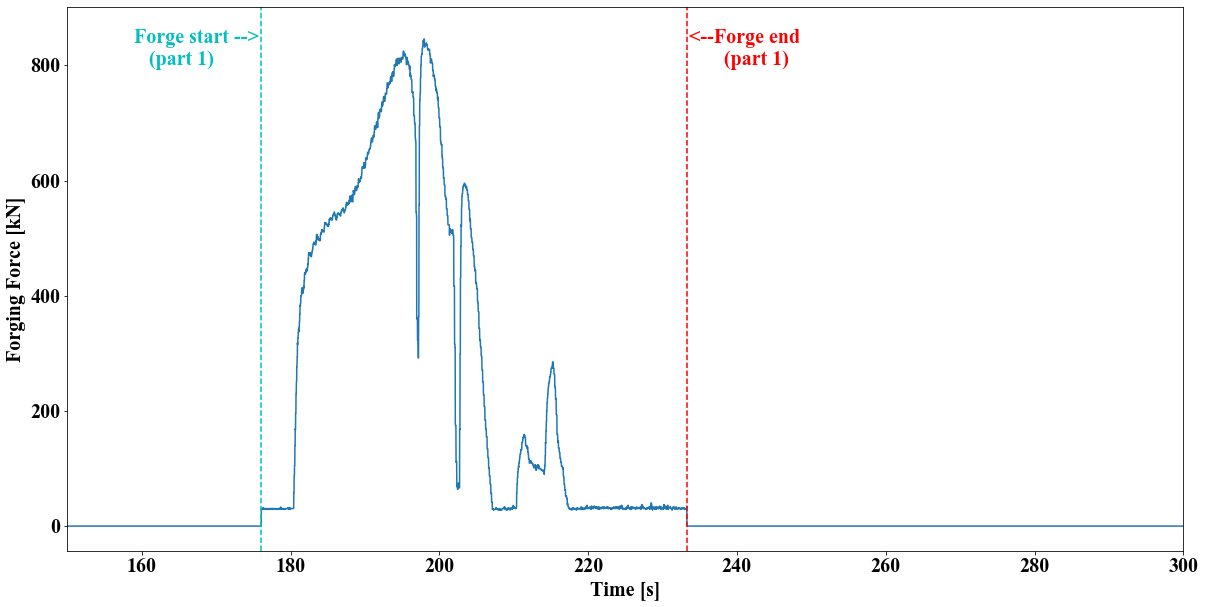

In [8]:
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(merged_data['Time [s]'], merged_data['Force [kN]'])    #Force [kN]
for index, row in forge_phases_times.iterrows():
    plt.axvline(row.forge_start_time, c='c', ls='--')
    plt.axvline(row.forge_stop_time, c='r', ls='--')
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Forging Force [kN]', fontsize=20)
plt.tick_params(labelsize=20)
plt.text(159,800, 'Forge start -->\n   (part 1)', color='c', fontsize=20)
plt.text(233.5,800, '<--Forge end \n       (part 1)', color='r',  fontsize=20)

plt.xlim([150,300]) # 5 forging cycles
plt.show()

### Sensor classification

In this part, again based on the **met4fof-strath-afrc-testbed** notebook, we will show most of the sensors and see what they are mesuring. Only small portion of sensors will be used for feature extraction because we expect that only some of them will have impact on final dimensions of the product.

Different sensors are relevant for different axes, and more details about the sensors is available in Excel file which came with the data:
`ForgedPartDataStructureSummaryv3.xlsx`.

In this file is the description for almost all the sensors. Description is about: which sensors are measuring different mechine axes, which sensors are not working, which sensors are not changing and at the end, which sensors are useful and which are not.

Machine axes are showed here:
![GFM Axes](static/GFM-Axes.png)




In [9]:
forging_sensors = set()

Actual value of forging drive power `Power [kW]`, hammer force `Force [kN]`, impacts per minute `Schlagzahl [1/min]` and Actual Value of eccentric shaft angle `EXZ_pos [deg]` are first four sensors that are taken. Rotation of eccentric shaft is making hammer's radial oscillations.

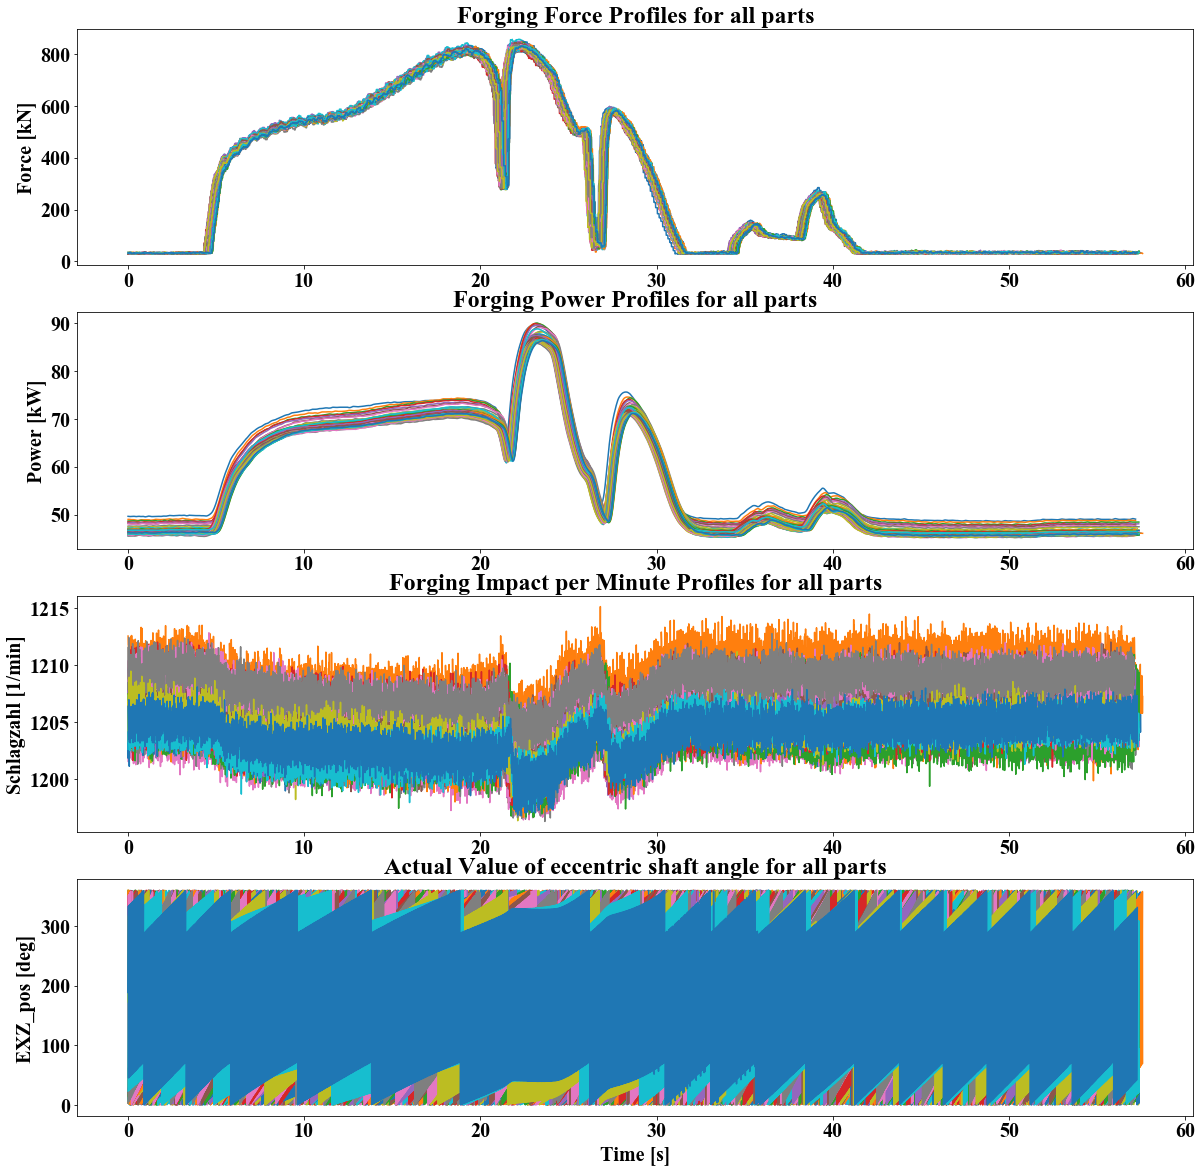

In [10]:
plt.figure(figsize=(20,20))

plt.subplot(411)
plt.title('A-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Force [kN]'].values)
#plt.xlabel('Time [s]')
plt.ylabel('Force [kN]')
plt.title('Forging Force Profiles for all parts')

plt.subplot(412)
plt.title('A-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Power [kW]'].values)
#plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.title('Forging Power Profiles for all parts')

plt.subplot(413)
plt.title('A-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Schlagzahl [1/min]'].values)
#plt.xlabel('Time [s]')
plt.ylabel('Schlagzahl [1/min]')
plt.title('Forging Impact per Minute Profiles for all parts')

plt.subplot(414)
plt.title('A-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['EXZ_pos [deg]'].values)
plt.xlabel('Time [s]')
plt.ylabel('EXZ_pos [deg]')
plt.title('Actual Value of eccentric shaft angle for all parts')

plt.show()

We will take first three of these four because maybe we'll use them. 

In [11]:
forging_sensors.update(['Power [kW]', 'Force [kN]','Schlagzahl [1/min]'])

#   dropped 
#  'EXZ_pos [deg]'  

For the A-Axis the following signals are available:

    'A_ACT_Force [kN]'
    'A_NOM_Force [kN]'   
    'A_ACTpos [mm]'
    'A_NOMpos [mm]'
    'A_ACTspd [mm/min]'
    'A_NOMspd [mm/min]'
    'A_OUT [%]'
    'Feedback A [%]'
    
It is recommended that the `A_NOM_Force [kN]` parameter should be ignored.

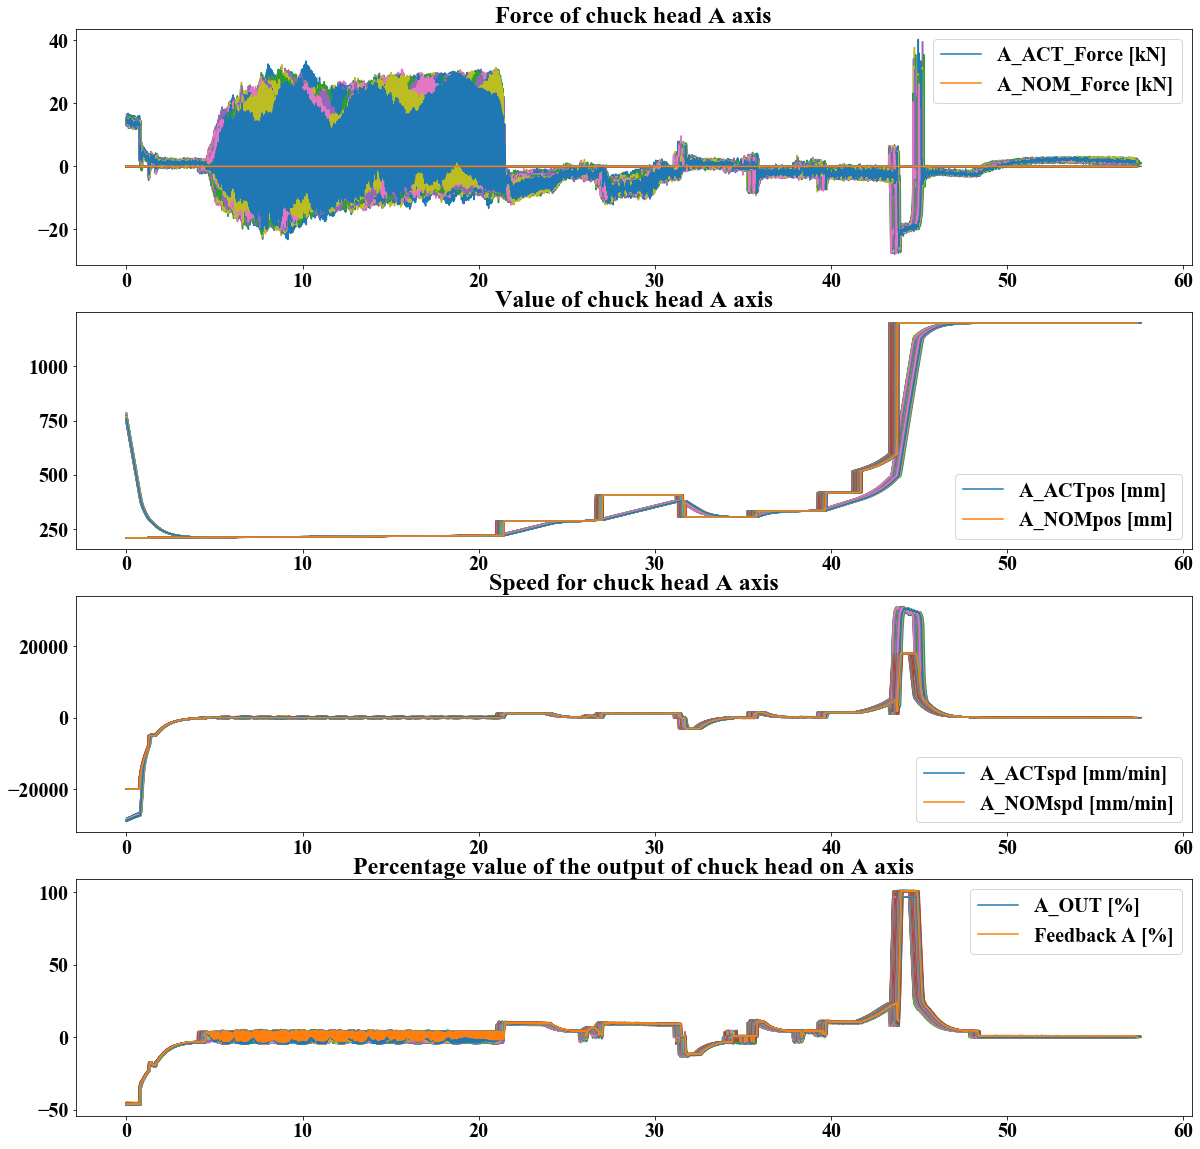

In [12]:
plt.figure(figsize=(20,20))

plt.subplot(411)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_ACT_Force [kN]'].values)# , label='A_ACT_Force [kN]')
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_NOM_Force [kN]'].values)# , label='A_NOM_Force [kN]')
#plt.xlabel('Time [s]')
plt.legend(['A_ACT_Force [kN]', 'A_NOM_Force [kN]'], loc=1)
plt.title('Force of chuck head A axis')

plt.subplot(412)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_ACTpos [mm]'].values)# , label='A_ACTpos [mm]')
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_NOMpos [mm]'].values)# , label='A_NOMpos [mm]')
#plt.xlabel('Time [s]')
plt.legend(['A_ACTpos [mm]', 'A_NOMpos [mm]'], loc=4)
plt.title('Value of chuck head A axis')

plt.subplot(413)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_ACTspd [mm/min]'].values)# , label='A_ACTspd [mm/min]')
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_NOMspd [mm/min]'].values)# , label='A_NOMspd [mm/min]')
#plt.xlabel('Time [s]')
plt.legend(['A_ACTspd [mm/min]', 'A_NOMspd [mm/min]'], loc=4)
plt.title('Speed for chuck head A axis')


plt.subplot(414)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_OUT [%]'].values)# , label='A_OUT [%]')
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Feedback A [%]'].values)# , label='Feedback A [%]')
#plt.xlabel('Time [s]')
plt.legend(['A_OUT [%]','Feedback A [%]'], loc=1)
plt.title('Percentage value of the output of chuck head on A axis')

plt.show()

We will not use these signals directly as features, but they can be used to find some characteristic points for splitting the forging phase. 

In [13]:
forging_sensors.update(['A_ACT_Force [kN]'])

# Adding features needed for segmentations of forging phase:
forging_sensors.update(['A_ACTpos [mm]','A_NOMpos [mm]'])

#dropped
#,'A_ACTpos [mm]','A_NOMpos [mm]','A_ACTspd [mm/min]','A_NOMspd [mm/min]','A_OUT [%]','Feedback A [%]'

The sensors for the mandrel (DB axis) are shown here:

    'DB_ACTpos [mm]'
    'DB_ACTspd [mm/min]'
    'DB_ACT_Force [kN]'
    'DB_NOMpos [mm]'
    'DB_OUT [%]'
    'DB_NOMspd [mm/min]'
    'DB_NOM_Force [kN]'
    'Feedback DB [%]'

**The `B_NOM_Force [kN]` parameter should be ignored.**


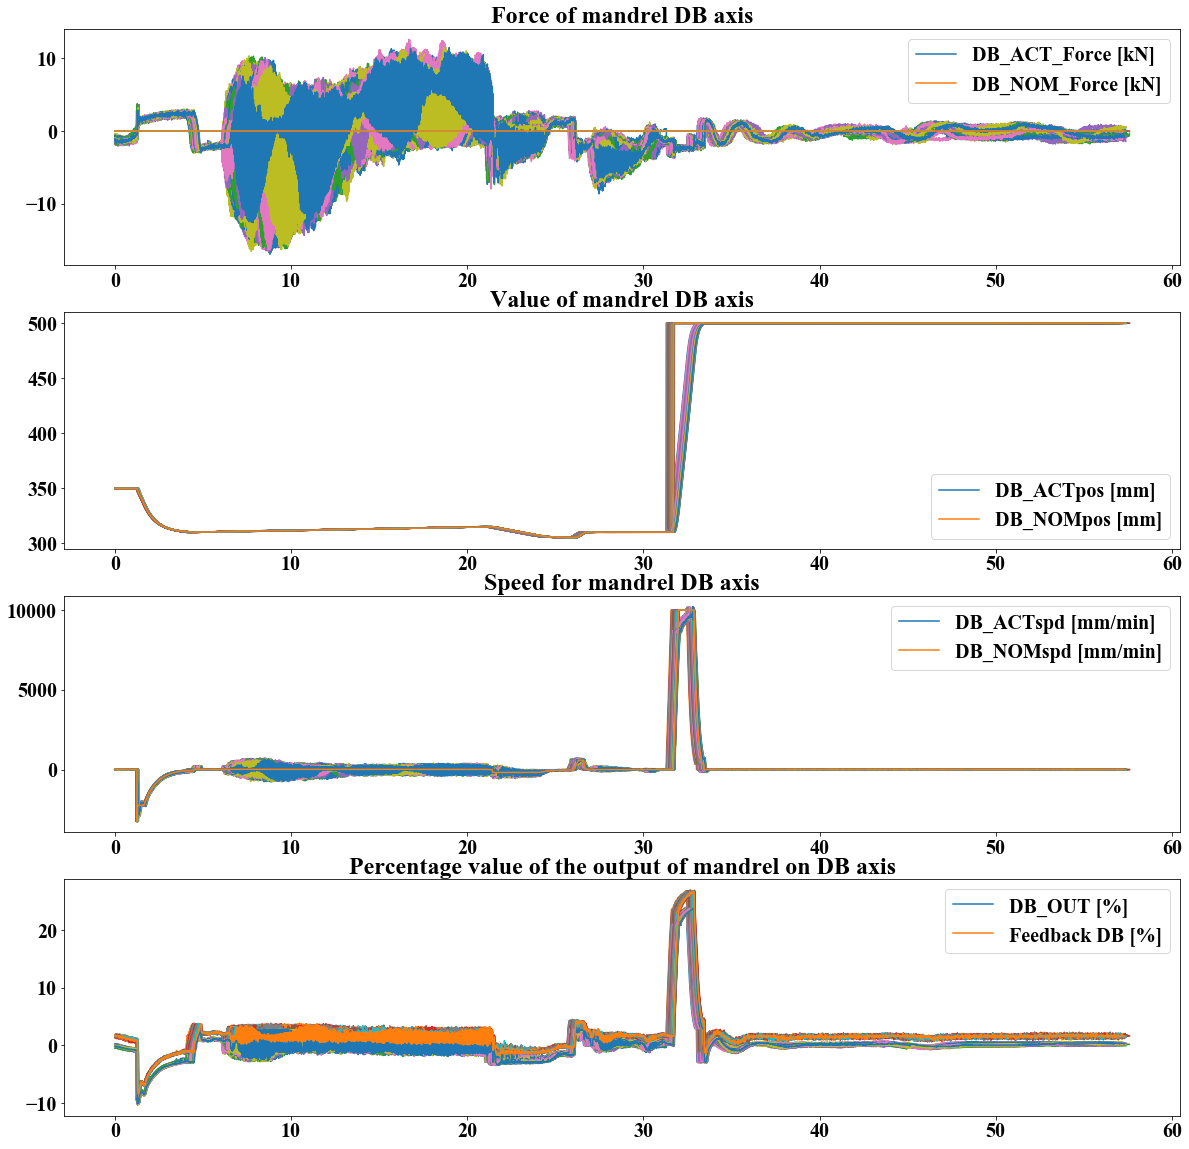

In [14]:
plt.figure(figsize=(20,20))

plt.subplot(411)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_ACT_Force [kN]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_NOM_Force [kN]'].values)
#plt.xlabel('Time [s]')
plt.legend(['DB_ACT_Force [kN]', 'DB_NOM_Force [kN]'], loc=1)
plt.title('Force of mandrel DB axis')

plt.subplot(412)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_ACTpos [mm]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_NOMpos [mm]'].values)
#plt.xlabel('Time [s]')
plt.legend(['DB_ACTpos [mm]', 'DB_NOMpos [mm]'], loc=4)
plt.title('Value of mandrel DB axis')

plt.subplot(413)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_ACTspd [mm/min]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_NOMspd [mm/min]'].values) 
#plt.xlabel('Time [s]')
plt.legend(['DB_ACTspd [mm/min]', 'DB_NOMspd [mm/min]'], loc=1)
plt.title('Speed for mandrel DB axis')


plt.subplot(414)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['DB_OUT [%]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Feedback DB [%]'].values)
#plt.xlabel('Time [s]')
plt.legend(['DB_OUT [%]','Feedback DB [%]'], loc=1)
plt.title('Percentage value of the output of mandrel on DB axis')


plt.show()

We will keep the mandrel force signal, but we won't use it probably at the beggining.

In [15]:
forging_sensors.update(['DB_ACT_Force [kN]'])

# dropped
#'DB_ACTpos [mm]','DB_ACTspd [mm/min]','DB_NOMpos [mm]','DB_OUT [%]','DB_NOMspd [mm/min]','Feedback DB [%]'

#### Sensors relevant for forging hammers.

For the L-Axis:

    'L_ACTpos [mm]'
    'L_ACTspd [mm/min]'
    'L_NOMpos [mm]'
    'L_OUT [%]'
    'L_NOMspd [mm/min]'
    'Feedback L [%]'

For the L-Axis:
    
    'R_ACTpos [mm]'
    'R_ACTspd [mm/min]'
    'R_NOMpos [mm]'
    'R_OUT [%]'
    'R_NOMspd [mm/min]'
    'Feedback R [%]'

For the SBA-Axis:

    'SBA_ActPos [mm]'
    'SBA_NomPos [mm] [mm]'
    'SBA_OUT [%]'
    'Feedback SBA [%]'


R and L axes signals are related to radial movement of the hammers, and they will be used to track hammers position relative to the part that is being forged. SBA axis is oscillatory motion of hammers and we are not expecting to much from these signals.

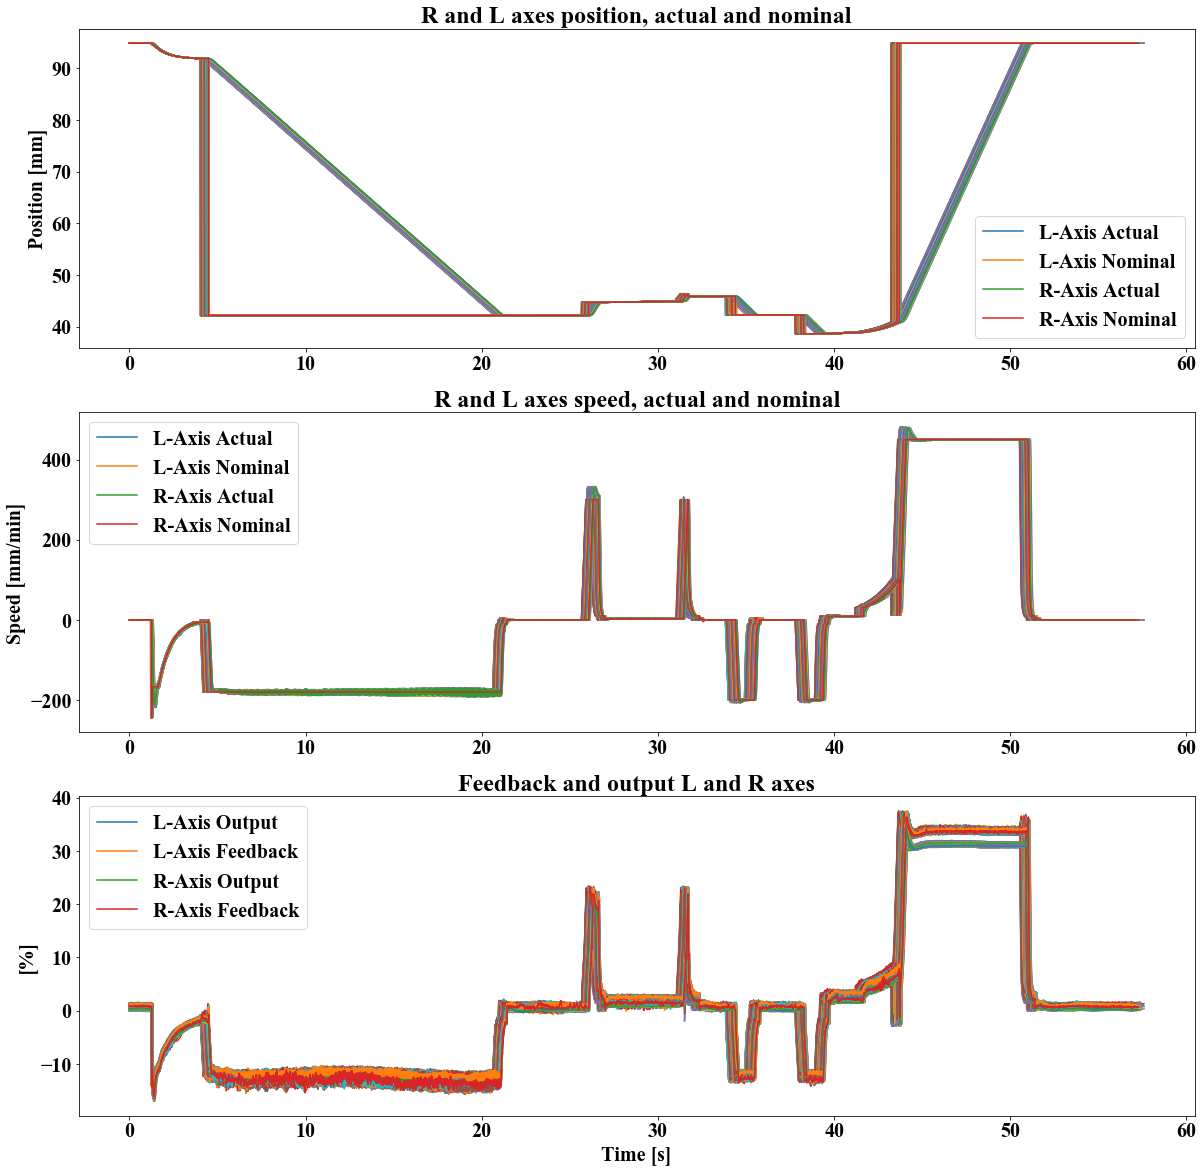

In [16]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.title('RL-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_ACTpos [mm]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_NOMpos [mm]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_ACTpos [mm]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_NOMpos [mm]'].values)
plt.ylabel('Position [mm]')
plt.title('R and L axes position, actual and nominal')
plt.legend(['L-Axis Actual', 'L-Axis Nominal', 'R-Axis Actual', 'R-Axis Nominal'], loc=4)

plt.subplot(312)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_ACTspd [mm/min]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_NOMspd [mm/min]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_ACTspd [mm/min]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_NOMspd [mm/min]'].values)
plt.ylabel('Speed [mm/min]')
plt.title('R and L axes speed, actual and nominal')
plt.legend(['L-Axis Actual', 'L-Axis Nominal', 'R-Axis Actual', 'R-Axis Nominal'], loc=2)

plt.subplot(313)
plt.title('A-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_OUT [%]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Feedback L [%]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_OUT [%]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Feedback R [%]'].values)
plt.ylabel('[%]')
plt.xlabel('Time [s]')
plt.title('Feedback and output L and R axes')
plt.legend(['L-Axis Output', 'L-Axis Feedback', 'R-Axis Output', 'R-Axis Feedback'], loc=2)

plt.show()

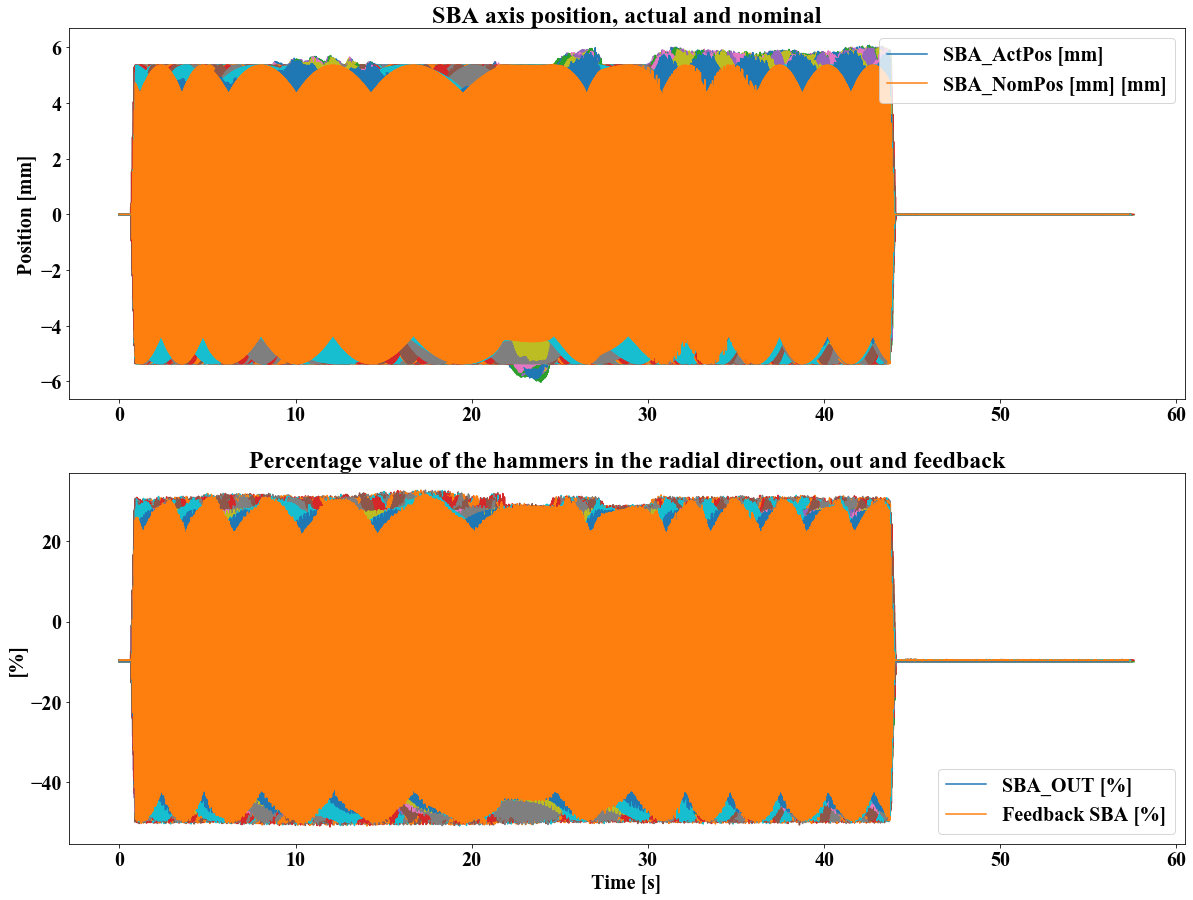

In [17]:
plt.figure(figsize=(20,15))

plt.subplot(211)
plt.title('SBA-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['SBA_ActPos [mm]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['SBA_NomPos [mm] [mm]'].values)
plt.ylabel('Position [mm]')
plt.title('SBA axis position, actual and nominal')
plt.legend(['SBA_ActPos [mm]', 'SBA_NomPos [mm] [mm]'], loc=1)

plt.subplot(212)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['SBA_OUT [%]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Feedback SBA [%]'].values)
plt.ylabel('[%]')
plt.title('Percentage value of the hammers in the radial direction, out and feedback')
plt.legend(['SBA_OUT [%]', 'Feedback SBA [%]'], loc=4)
plt.xlabel('Time [s]')

plt.show()

In [18]:
forging_sensors.update(['SBA_ActPos [mm]'])

# Adding features needed for segmentations of forging phase:
forging_sensors.update(['L_ACTpos [mm]','L_NOMpos [mm]', 'R_ACTpos [mm]','R_NOMpos [mm]'])

# dropped
#'L_ACTpos [mm]','L_ACTspd [mm/min]','L_NOMpos [mm]','L_OUT [%]','L_NOMspd [mm/min]','Feedback L [%]','R_ACTpos [mm]','R_ACTspd [mm/min]','R_NOMpos [mm]','R_OUT [%]','R_NOMspd [mm/min]','Feedback R [%]','SBA_ActPos [mm]','SBA_NomPos [mm] [mm]','SBA_OUT [%]','Feedback SBA [%]'

### Temperatures relevant for forging phase...

Temperatures considered relevant for forging phase are temperature of the forging box and temperatures of obtained with pyrometer just before and after the forging phase.

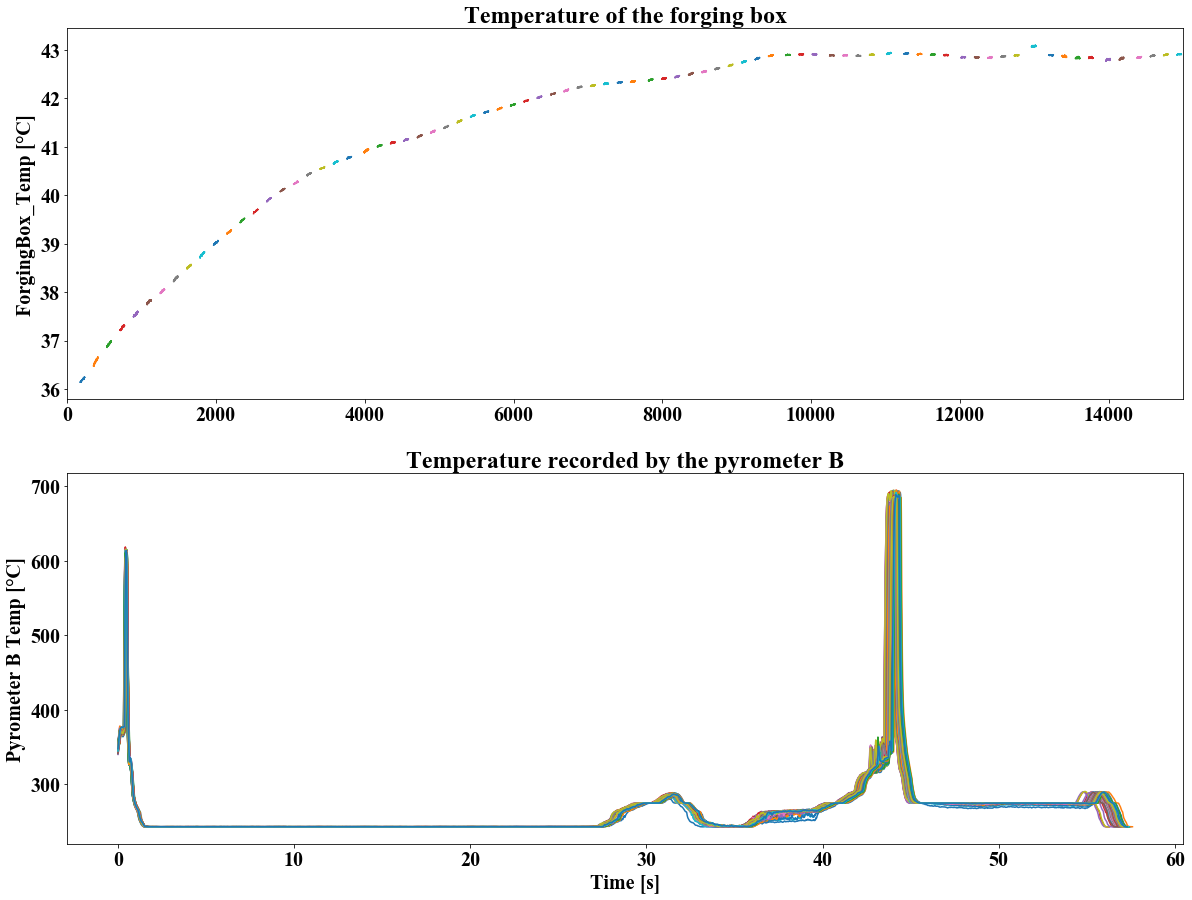

In [19]:
plt.figure(figsize=(20,15))

plt.subplot(211)
plt.title('Temperature Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values,y['ForgingBox_Temp'].values)
plt.ylabel('ForgingBox_Temp [°C]')
plt.title('Temperature of the forging box')
plt.xlim(0,15000)

plt.subplot(212)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['TMP_Ind_F [°C]'].values)
plt.ylabel('Pyrometer B Temp [°C]')
plt.title('Temperature recorded by the pyrometer B')
plt.xlabel('Time [s]')


plt.show()

In [20]:
forging_sensors.update(['ForgingBox_Temp', 'TMP_Ind_F [°C]'])

In [21]:
print("Sensors extracted for forging phase are:")
forging_sensors

Sensors extracted for forging phase are:


{'A_ACT_Force [kN]',
 'A_ACTpos [mm]',
 'A_NOMpos [mm]',
 'DB_ACT_Force [kN]',
 'Force [kN]',
 'ForgingBox_Temp',
 'L_ACTpos [mm]',
 'L_NOMpos [mm]',
 'Power [kW]',
 'R_ACTpos [mm]',
 'R_NOMpos [mm]',
 'SBA_ActPos [mm]',
 'Schlagzahl [1/min]',
 'TMP_Ind_F [°C]'}

In [22]:
forge_data=pd.DataFrame(merged_data[forging_sensors])

We will keep the time column and ID labels.

In [23]:
forge_data['Timer Tick [ms]']=merged_data['Timer Tick [ms]']
forge_data['traceID']=merged_data['traceID'].values
forge_data['Time [s]']=merged_data['Time [s]'].values

forge_data.head()
#forge_data.tail()

,DB_ACT_Force [kN],Power [kW],A_ACT_Force [kN],Schlagzahl [1/min],SBA_ActPos [mm],L_NOMpos [mm],R_NOMpos [mm],A_ACTpos [mm],L_ACTpos [mm],R_ACTpos [mm],TMP_Ind_F [°C],A_NOMpos [mm],ForgingBox_Temp,Force [kN],Timer Tick [ms],traceID,Time [s]
0,3.801680,50.453915,-4.837847,1207.22081,-0.020,94.9,94.9,1207.685,79.921259,79.920872,242.753787,1200.0,35.874131,0.0,2594955190,1,0.00
1,2.836382,50.454423,-2.926372,1209.64038,-0.020,94.9,94.9,1207.685,79.925348,79.925306,242.784148,1200.0,35.874370,0.0,2594955200,1,0.01
2,2.518575,50.453662,9.374414,1205.96980,-0.025,94.9,94.9,1207.680,79.930455,79.931276,242.761722,1200.0,35.874607,0.0,2594955210,1,0.02
3,2.108604,50.450142,9.238096,1210.00307,-0.025,94.9,94.9,1207.550,79.937327,79.938360,242.737371,1200.0,35.874920,0.0,2594955220,1,0.03
4,2.232559,50.447115,0.630200,1209.25234,-0.025,94.9,94.9,1207.240,79.946579,79.948206,242.735159,1200.0,35.875307,0.0,2594955230,1,0.04


From `1_Importing_the_Target(Output)_Matrix` we know that a lot of output values are availiable for prediction. Now we will try to examine which parts of forging phase are relevant for which output value. The idea is to have a look at the axes movement, and to correlate that movement to different spatial locations on final part. Dimensions of part at these spatial locations is to be predicted.

Maybe if we plot displacements for two most important axes, we could notice time periods when specific dimensions are affected. We will plot chuck head axis actual position (A) and hammers displacement (R and L axes).

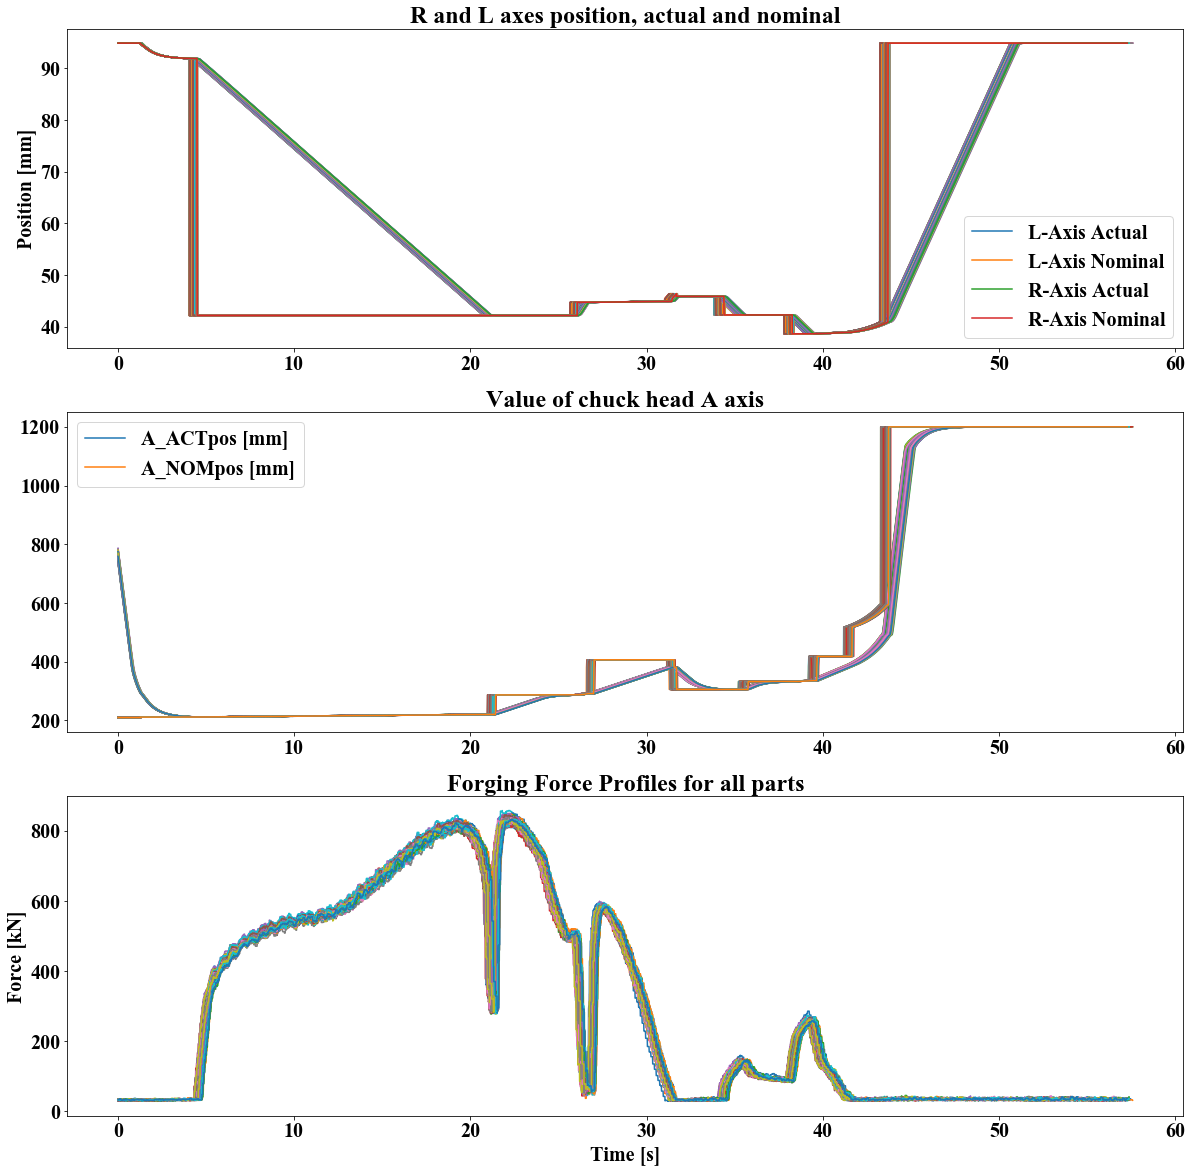

In [24]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.title('RL-Axis Signals')

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_ACTpos [mm]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['L_NOMpos [mm]'].values)
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_ACTpos [mm]'].values) 
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['R_NOMpos [mm]'].values)
plt.ylabel('Position [mm]')
#plt.ylim(38,46)
plt.title('R and L axes position, actual and nominal')
plt.legend(['L-Axis Actual', 'L-Axis Nominal', 'R-Axis Actual', 'R-Axis Nominal'], loc=4)

plt.subplot(312)

for index, row in forge_phases.iterrows():
    y=merged_data[row.forge_start_ind:row.forge_stop_ind]
    x=merged_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_ACTpos [mm]'].values)# , label='A_ACTpos [mm]')
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['A_NOMpos [mm]'].values)# , label='A_NOMpos [mm]')
#plt.xlabel('Time [s]')
#plt.ylim(210,422)
plt.legend(['A_ACTpos [mm]', 'A_NOMpos [mm]'], loc=2)
plt.title('Value of chuck head A axis')

plt.subplot(313)

for index, row in forge_phases.iterrows():
    y=forge_data[row.forge_start_ind:row.forge_stop_ind]
    x=forge_data[row.forge_start_ind:row.forge_stop_ind]
    plt.plot(x['Time [s]'].values-x['Time [s]'].values[0],y['Force [kN]'].values)
plt.xlabel('Time [s]')
plt.ylabel('Force [kN]')
plt.title('Forging Force Profiles for all parts')
plt.show()

Plotting A vs R-L movement...

For better understanding of forging proces, drawing of final part is imported and hammers movement relative to the final part can be seen on next two graphs. First plot is showing nominal (setpoint) values for hammer movement, and second graph showing actual positions gives very good matching between picture and graph lines.

This is useful because now we now which segment is forged at which point of time, and then forging phase can be separated into smaller phases.

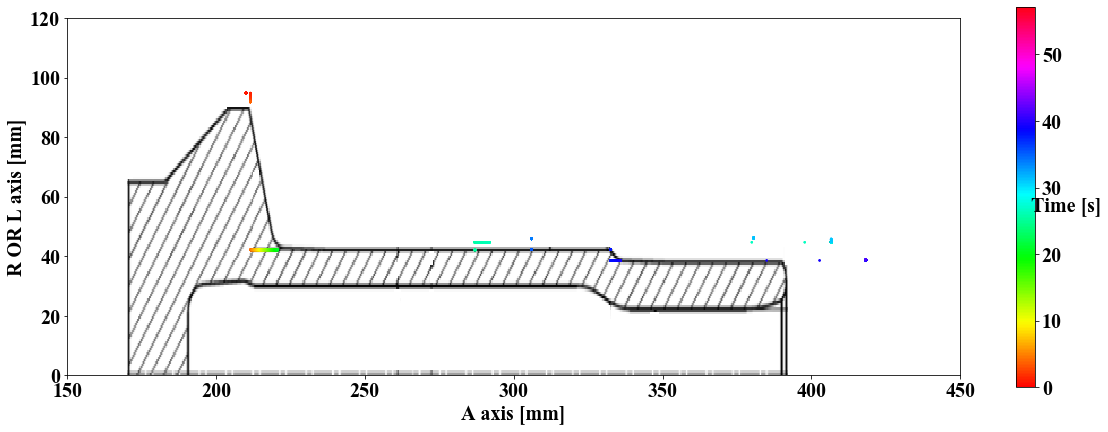

In [25]:
plt.figure(figsize=(20,7))

img = plt.imread("pictures/part.png")


plt.imshow(img, extent=[170, 392, 0, 90])

for index, row in forge_phases.iloc[:1,:].iterrows():
    y=forge_data[row.forge_start_ind:row.forge_stop_ind]
    x=forge_data[row.forge_start_ind:row.forge_stop_ind]
    plt.scatter(y['A_NOMpos [mm]'].values,y['L_NOMpos [mm]'].values,s=2, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
    plt.scatter(y['A_NOMpos [mm]'].values,y['R_NOMpos [mm]'].values,s=2, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
plt.ylabel('R OR L axis [mm]')
plt.xlabel('A axis [mm]')
plt.xlim(150,450)
plt.ylim(0,120)
plt.colorbar().set_label('Time [s]',fontsize=20 ,rotation=0)

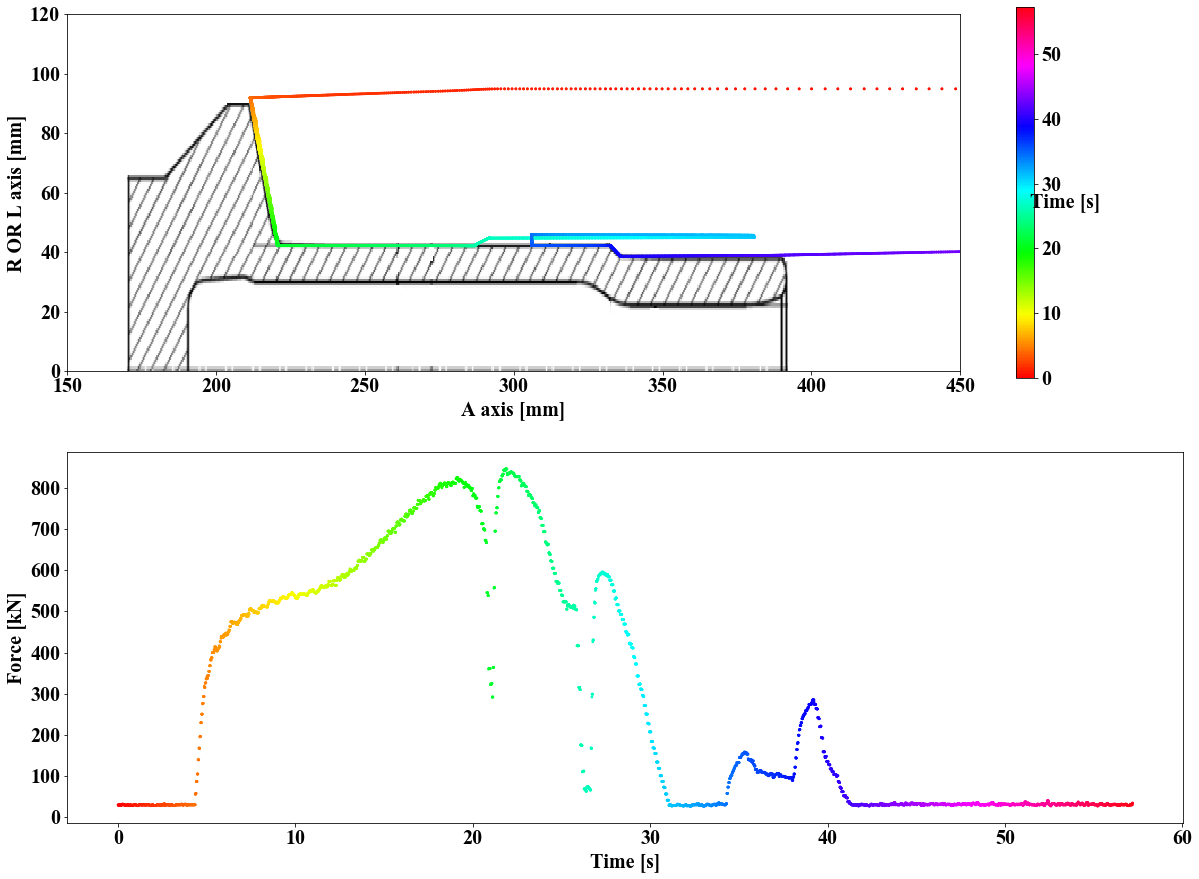

In [26]:
plt.figure(figsize=(20,15))

plt.subplot(211)
plt.imshow(img, extent=[170, 392, 0, 90])

for index, row in forge_phases.iloc[:1,:].iterrows():
    y=forge_data[row.forge_start_ind:row.forge_stop_ind]
    x=forge_data[row.forge_start_ind:row.forge_stop_ind]
    plt.scatter(y['A_ACTpos [mm]'].values,y['L_ACTpos [mm]'].values, s=3, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
    plt.scatter(y['A_ACTpos [mm]'].values,y['R_ACTpos [mm]'].values, s=3, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
plt.ylabel('R OR L axis [mm]')
plt.xlabel('A axis [mm]')
plt.xlim(150,450)
plt.ylim(0,120)
plt.colorbar().set_label('Time [s]',fontsize=20 ,rotation=0)

plt.subplot(212)
for index, row in forge_phases.iloc[:1,:].iterrows():
    y=forge_data[row.forge_start_ind:row.forge_stop_ind]
    x=forge_data[row.forge_start_ind:row.forge_stop_ind]
    plt.scatter(x['Time [s]'].values-x['Time [s]'].values[0],y['Force [kN]'].values, s=3, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
plt.ylabel('Force [kN]')
plt.xlabel('Time [s]')

plt.show()

From graphs above,we see that the Force graph can be mapped to the spatial locoations of the part. Using these colors, which represent time, we will map the force to the part in 3D graph...

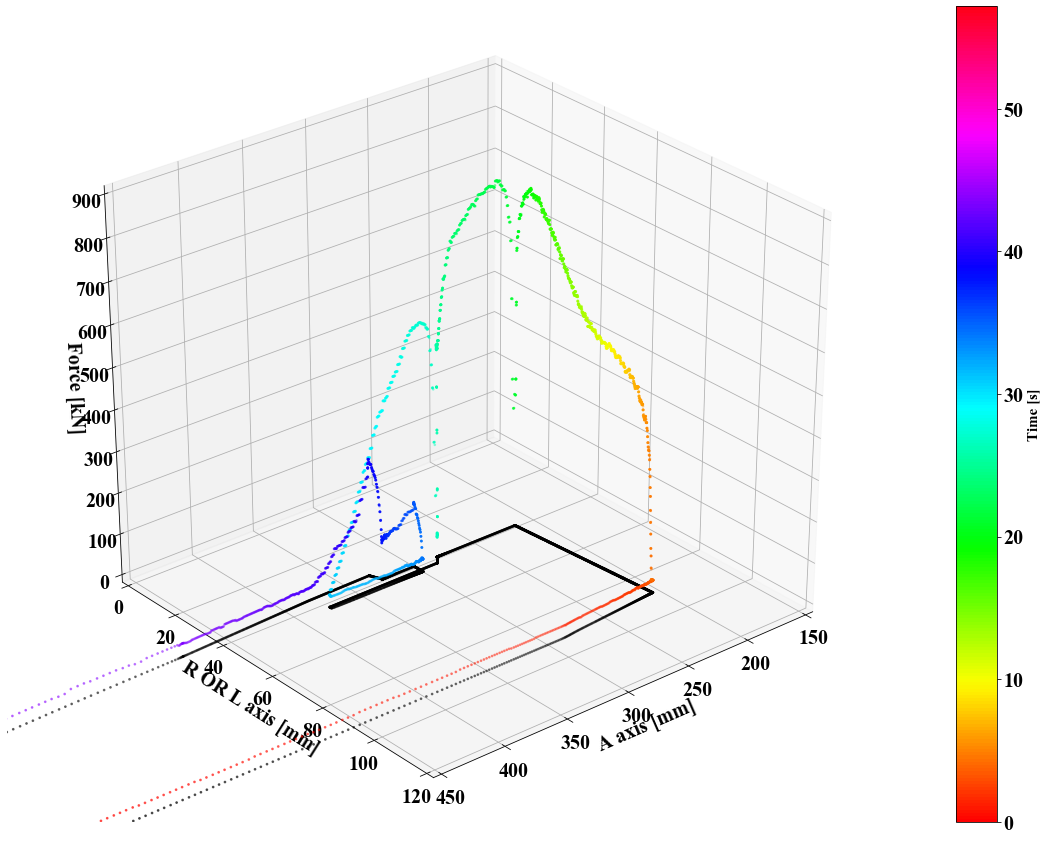

In [27]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

#ax.imshow(img, extent=[170, 392, 0, 90])

for index, row in forge_phases.iloc[:1,:].iterrows():
    y=forge_data[row.forge_start_ind:row.forge_stop_ind]
    x=forge_data[row.forge_start_ind:row.forge_stop_ind]
    p=ax.scatter(y['A_ACTpos [mm]'].values,y['L_ACTpos [mm]'].values,y['Force [kN]'].values, s=3, c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
    ax.scatter(y['A_ACTpos [mm]'].values,y['R_ACTpos [mm]'].values, s=3, c="black")#c=x['Time [s]'].values-x['Time [s]'].values[0], cmap="hsv")
ax.set_xlim(150,450)
ax.set_ylim(0,120)
ax.set_zlim(0,900)
ax.set_xlabel('A axis [mm]')
ax.set_ylabel('R OR L axis [mm]')
ax.set_zlabel('Force [kN]')
fig.colorbar(p).set_label('Time [s]',fontsize=15)

#ax.set_colorbar().set_label('Time [s]',fontsize=20 ,rotation=0)

ax.view_init(30, 50)

After looking at this picture, it is clear that forging phase can be separated into 5 phases. It will be done using spatial setpoints because each phase is determined by start and end setpoint. 
`real_forge` is part od the data from the first moment hammer tuches the part, until the last touch.

## Forging phases segmentation..

In [28]:
real_forge = []

for index, row in forge_phases.iterrows():
    part_real_forge_df = forge_data[row.forge_start_ind:row.forge_stop_ind].copy()
    part_real_forge_df['partID']=part_real_forge_df.iloc[part_real_forge_df.index==row.forge_start_ind]['traceID'].values[0]
    part_real_forge_df['Time [s]']=part_real_forge_df['Time [s]']-part_real_forge_df['Time [s]'].iloc[0]
    real_forge.append(part_real_forge_df)
    #plt.plot(part_real_forge_df['Force [kN]'].values)
    part_real_forge_df.set_index('Time [s]', inplace=True)

real_forge_df=pd.concat(real_forge)
real_forge_df.set_index('partID', append=True, inplace=True)

We will have a look at one of 81 parts. `phase` column will be added and used as categorical to describe segments of forging.

In [29]:
df=real_forge[0]
df['phase']='forging'
# Make `phase` column a categorical column
df.loc[:,'phase']=df[['phase']].apply(lambda x: x.astype('category', copy=False))
#real_forge_df

If we apply the function $diff()$ on R and A axes nominal positions and then find the peaks for that signal, points of sudden changes of setpoints will be found. We need to decide, which peaks out of all we will take to separate to 5 planned phases. $diff(f)$ function has peaks when $f$ has big changes.

Text(0.5, 0, 'Time [s]')

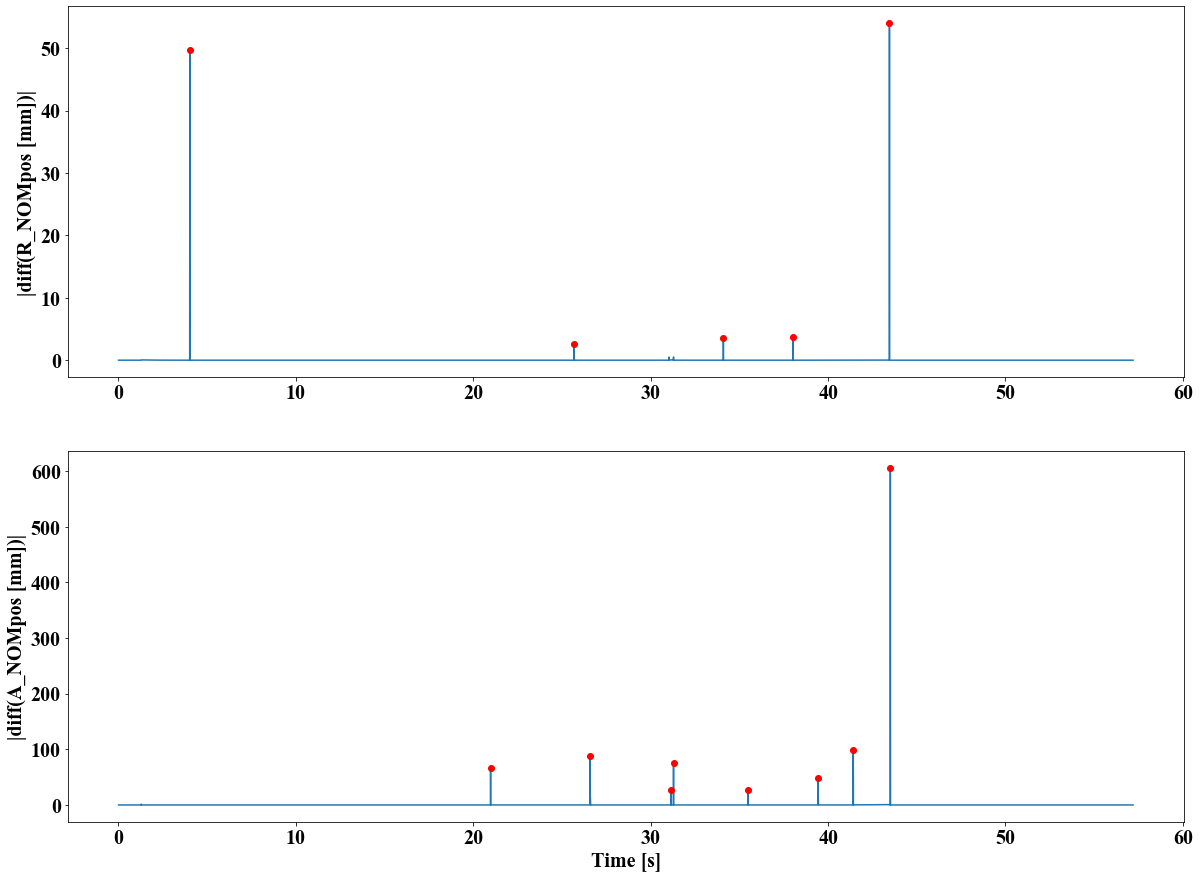

In [30]:
plt.figure(figsize=(20,15))

plt.subplot(211)

plt.plot(np.abs(df['R_NOMpos [mm]'].diff()))
## Find in froging
peaksR, _ = find_peaks(np.abs(df['R_NOMpos [mm]'].diff()), height=1)
plt.plot(df.index[peaksR], np.abs(df['R_NOMpos [mm]'].diff().iloc[peaksR]), 'o', color="r" )
plt.ylabel("|diff(R_NOMpos [mm])|")

plt.subplot(212)

plt.plot(np.abs(df['A_NOMpos [mm]'].diff()))
## Find in froging
peaksA, _ = find_peaks(np.abs(df['A_NOMpos [mm]'].diff()), height=2)
plt.plot(df.index[peaksA], np.abs(df['A_NOMpos [mm]'].diff().iloc[peaksA]), 'o', color="r" )
plt.ylabel("|diff(A_NOMpos [mm])|")
plt.xlabel("Time [s]")



Yellow lines represent peaks from hammers axis (R), and red lines are changes in A axis setpoints.

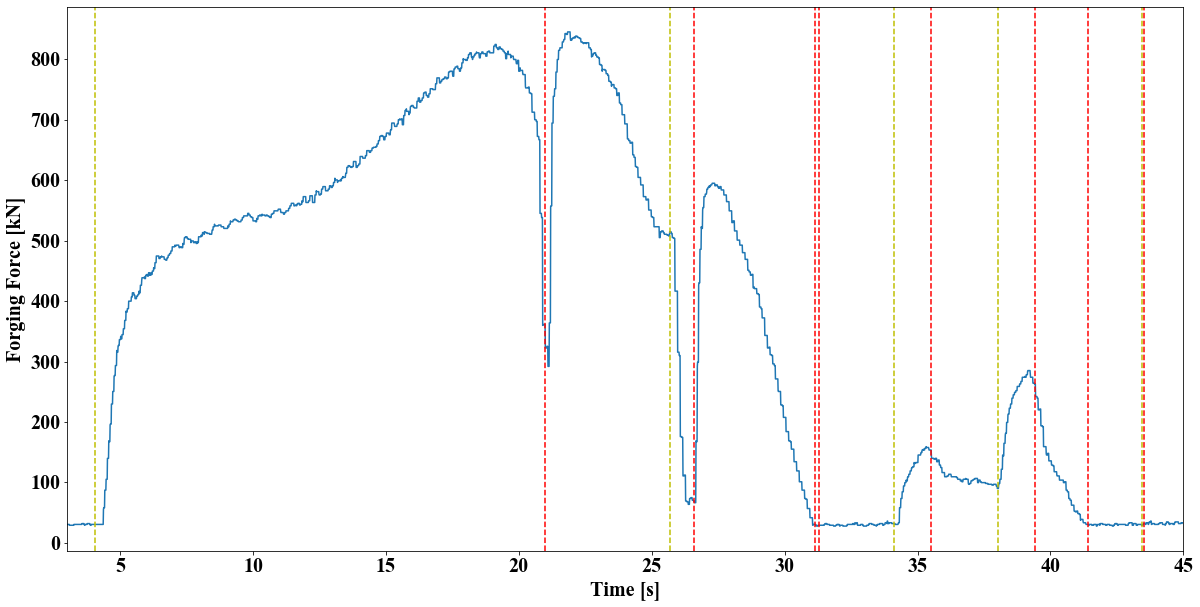

In [31]:
plt.figure(figsize=(20,10))
plt.plot(df['Force [kN]'])    #Force [kN]

for peak in peaksR:
    plt.axvline(df.index[peak], c='y', ls='--')

for peak in peaksA:
    plt.axvline(df.index[peak], c='r', ls='--')

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Forging Force [kN]', fontsize=20)
plt.tick_params(labelsize=20)
plt.xlim(3,45)
plt.show()

Classification of segments based on showed signals. Categorical column `phase` will store marks for phases of forging.

In [32]:
df['phase']='forging'
df.loc[df.index[peaksR[0]]:df.index[peaksA[0]],'phase']='forging_phase_1'
df.loc[df.index[peaksA[0]]:df.index[peaksR[1]],'phase']='forging_phase_2'
df.loc[df.index[peaksA[1]]:df.index[peaksA[2]],'phase']='forging_phase_3'
df.loc[df.index[peaksR[2]]:df.index[peaksR[3]],'phase']='forging_phase_4'
df.loc[df.index[peaksR[3]]:df.index[peaksA[6]],'phase']='forging_phase_5'

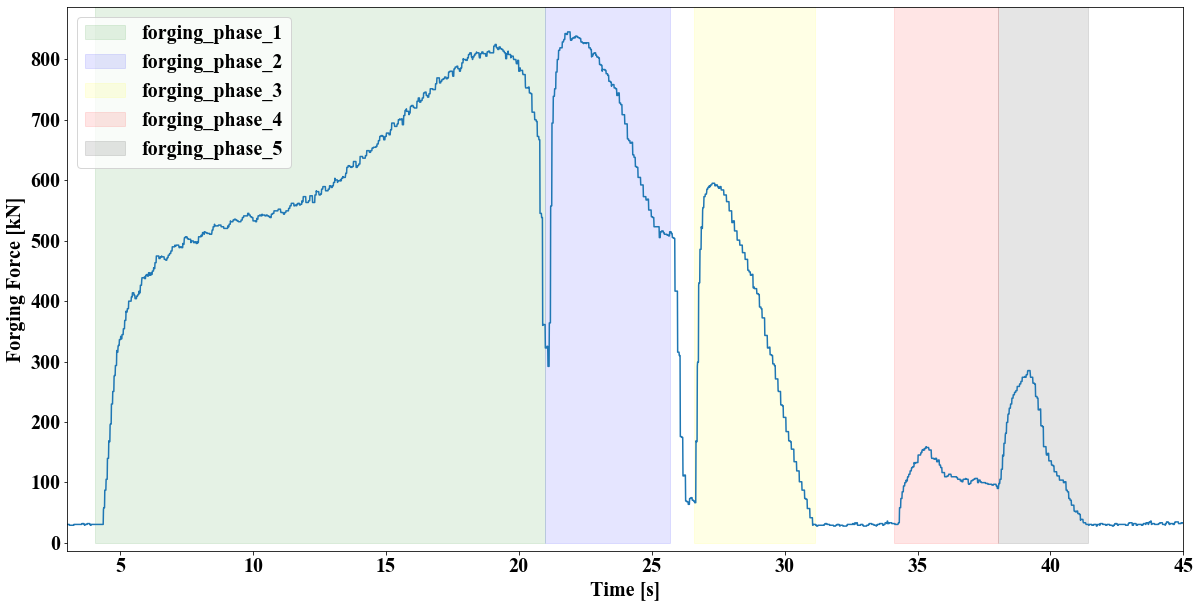

In [33]:
f=plt.figure(figsize=(20,10))
ax=f.add_subplot(111)

ax.plot(df['Force [kN]'])    #Force [kN]

start = df.query('phase=="forging_phase_1"').index[0]
stop = df.query('phase=="forging_phase_1"').index[-1]
rect = plt.Rectangle((start, 0), stop-start, 900, color='green', alpha=0.1, label='forging_phase_1')
ax.add_patch(rect)

start = df.query('phase=="forging_phase_2"').index[0]
stop = df.query('phase=="forging_phase_2"').index[-1]
rect = plt.Rectangle((start, 0), stop-start, 900, color='blue', alpha=0.1, label='forging_phase_2')
ax.add_patch(rect)

start = df.query('phase=="forging_phase_3"').index[0]
stop = df.query('phase=="forging_phase_3"').index[-1]
rect = plt.Rectangle((start, 0), stop-start, 900, color='yellow', alpha=0.1, label='forging_phase_3')
ax.add_patch(rect)

start = df.query('phase=="forging_phase_4"').index[0]
stop = df.query('phase=="forging_phase_4"').index[-1]
rect = plt.Rectangle((start, 0), stop-start, 900, color='red', alpha=0.1, label='forging_phase_4')
ax.add_patch(rect)

start = df.query('phase=="forging_phase_5"').index[0]
stop = df.query('phase=="forging_phase_5"').index[-1]
rect = plt.Rectangle((start, 0), stop-start, 900, color='black', alpha=0.1, label='forging_phase_5')
ax.add_patch(rect)

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Forging Force [kN]', fontsize=20)
plt.tick_params(labelsize=20)
plt.xlim(3,45)
plt.legend()
plt.show()

Applying this pattern for all parts..

In [34]:
for idx, df in enumerate(real_forge):
    df['phase']='forging'
    # Make `phase` column a categorical column
    df.loc[:,'phase']=df[['phase']].apply(lambda x: x.astype('category', copy=False))
    ##
    peaksR, _ = find_peaks(np.abs(df['R_NOMpos [mm]'].diff()), height=1)
    assert(len(peaksR)==5) # Through an error is the number of peak is not exactly 5
    peaksA, _ = find_peaks(np.abs(df['A_NOMpos [mm]'].diff()), height=2)
    assert(len(peaksA)==8) # Through an error is the number of peak is not exactly 8
    ##
    df['phase']='forging'
    df.loc[df.index[peaksR[0]]:df.index[peaksA[0]],'phase']='forging_phase_1'
    df.loc[df.index[peaksA[0]]:df.index[peaksR[1]],'phase']='forging_phase_2'
    df.loc[df.index[peaksA[1]]:df.index[peaksA[2]],'phase']='forging_phase_3'
    df.loc[df.index[peaksR[2]]:df.index[peaksR[3]],'phase']='forging_phase_4'
    df.loc[df.index[peaksR[3]]:df.index[peaksA[6]],'phase']='forging_phase_5'


Now we can plot each subphase sparately, and compare them one by one for parts. Their lenghts are almost the same, but with small differences. From every of these segments, we can extract different features.

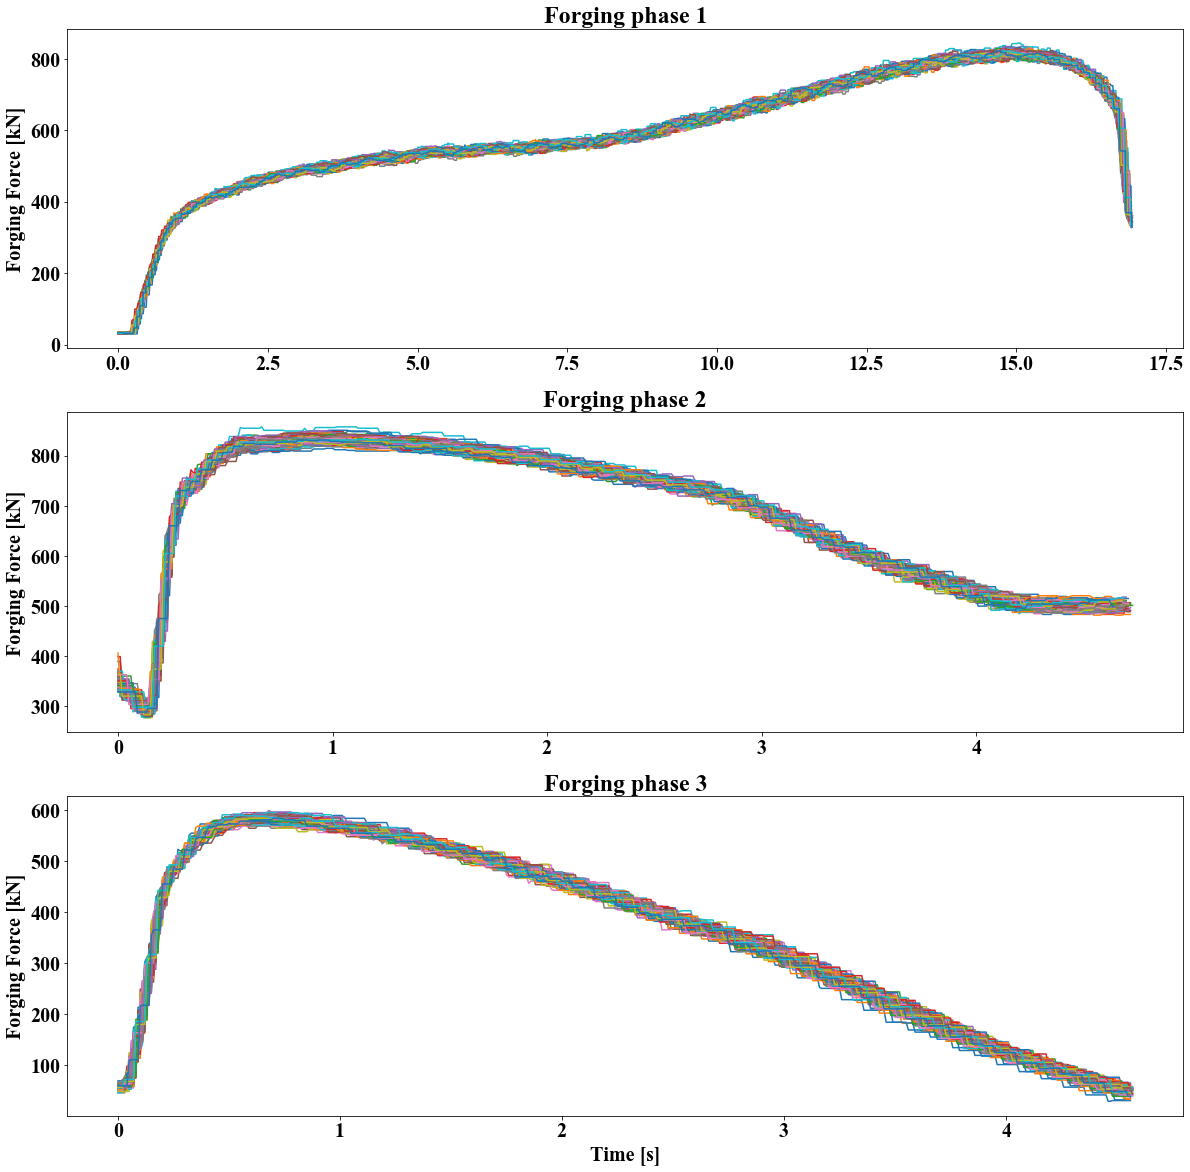

In [35]:
fig=plt.figure(figsize=(20,20))

ax=fig.add_subplot(311)
ax.set_title("Forging phase 1")
plt.ylabel('Forging Force [kN]', fontsize=20)

for idx, df in enumerate(real_forge):
    #print(len(df.query('phase=="forging_phase_1"').index))
    ax.plot(df.query('phase=="forging_phase_1"').index-df.query('phase=="forging_phase_1"').index[0], df.query('phase=="forging_phase_1"')['Force [kN]'].values)

ax=fig.add_subplot(312)
ax.set_title("Forging phase 2")
plt.ylabel('Forging Force [kN]', fontsize=20)
                      
for idx, df in enumerate(real_forge):
    #print(len(df.query('phase=="forging_phase_2"').index))
    ax.plot(df.query('phase=="forging_phase_2"').index-df.query('phase=="forging_phase_2"').index[0],df.query('phase=="forging_phase_2"')['Force [kN]'].values)

ax=fig.add_subplot(313)
ax.set_title("Forging phase 3")
plt.ylabel('Forging Force [kN]', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
           
for idx, df in enumerate(real_forge):
    #print(len(df.query('phase=="forging_phase_3"').index))
    ax.plot(df.query('phase=="forging_phase_3"').index-df.query('phase=="forging_phase_3"').index[0],df.query('phase=="forging_phase_3"')['Force [kN]'].values)
    



## Force characteristic points... and Force features..

First characteristic points for each of segments are maximum values (peaks).

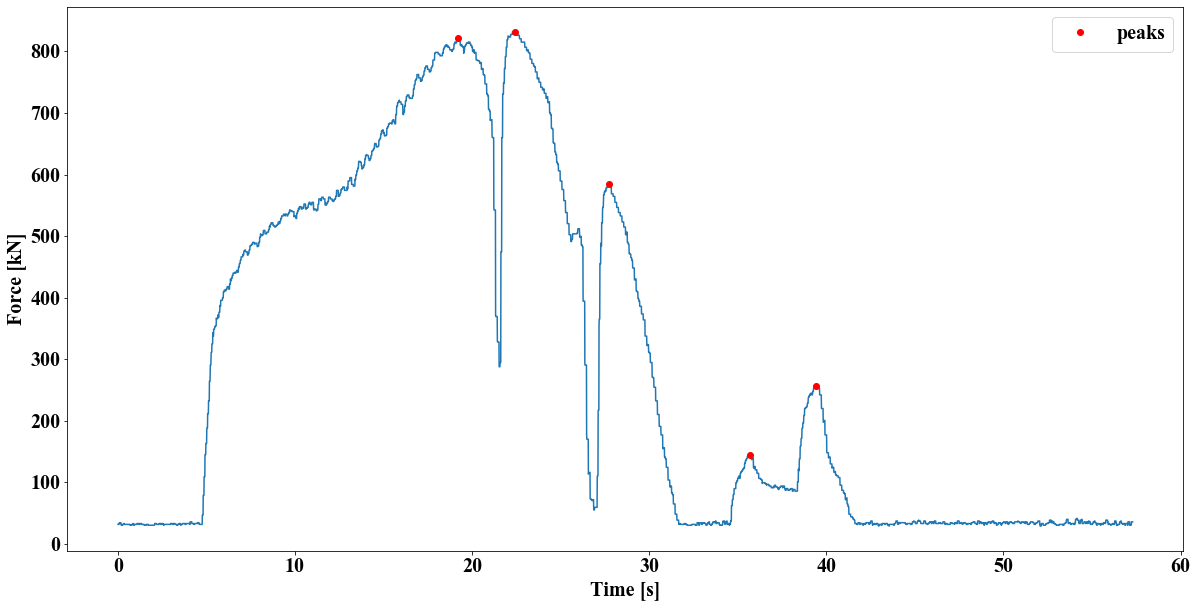

In [36]:
plt.plot(df['Force [kN]'])

peaksForce, _ = find_peaks(df['Force [kN]'], height=100, prominence=30, distance=70)
plt.plot(df.index[peaksForce], df['Force [kN]'].iloc[peaksForce], 'o', color="r" , label="peaks")
plt.xlabel("Time [s]")
plt.ylabel("Force [kN]")
plt.legend()

First features we are going to extract are maximum values, and rates of increase and deacrease of force in each phase. 
Rates of change for one phase are calculates as linear relationship.

Rate of increase for phase one is:
$$ROI1\bigg[\frac{kN}{s}\bigg]=\frac{Force_{max}-Force(t_{0})}{\delta t_{1}}$$  
and rate of decrease for phase one is:
$$ROD1\bigg[\frac{kN}{s}\bigg]=\frac{Force_{max}-Force(t_{last})}{\delta t_{2}}$$


where $t_{0}$ is beggining of subphase and $t_{last}$ is end of the subphase, and $\delta t_{1}$ and $\delta t_{2}$ are durations of increasing and decreasing parts, respectively.

In [37]:
forging_force_features = pd.DataFrame(index=pd.RangeIndex(1,len(data)+1))

forging_force_features['Forging Time [s]']=np.nan

forging_force_features['Forging Phase 1 Force Max [kN]']=np.nan
forging_force_features['Forging Phase 1 Force ROI [kN/s]']=np.nan
forging_force_features['Forging Phase 1 Force ROD [kN/s]']=np.nan
forging_force_features['Forging Phase 1 Force Integral [kNs]']=np.nan

forging_force_features['Forging Phase 2 Force Max [kN]']=np.nan
forging_force_features['Forging Phase 2 Force ROI [kN/s]']=np.nan
forging_force_features['Forging Phase 2 Force ROD [kN/s]']=np.nan
forging_force_features['Forging Phase 2 Force Integral [kNs]']=np.nan

forging_force_features['Forging Phase 3 Force Max [kN]']=np.nan
forging_force_features['Forging Phase 3 Force ROI [kN/s]']=np.nan
forging_force_features['Forging Phase 3 Force ROD [kN/s]']=np.nan
forging_force_features['Forging Phase 3 Force Integral [kNs]']=np.nan

forging_force_features['Forging Phase 4 Force Max [kN]']=np.nan
forging_force_features['Forging Phase 4 Force ROI [kN/s]']=np.nan
forging_force_features['Forging Phase 4 Force ROD [kN/s]']=np.nan
forging_force_features['Forging Phase 4 Force Integral [kNs]']=np.nan

forging_force_features['Forging Phase 5 Force Max [kN]']=np.nan
forging_force_features['Forging Phase 5 Force ROI [kN/s]']=np.nan
forging_force_features['Forging Phase 5 Force ROD [kN/s]']=np.nan
forging_force_features['Forging Phase 5 Force Integral [kNs]']=np.nan

In [38]:
for idx, df in enumerate(real_forge):
    force=df['Force [kN]']
    forging_force_features['Forging Time [s]'][idx+1]=df.index[-1]-df.index[0]
    peaksForce, _ = find_peaks(force, height=100, prominence=30, distance=70)
    #print(idx, peaksForce)
    assert(len(peaksForce)==5)
    
    force1=df.query('phase=="forging_phase_1"')['Force [kN]'].values
    forging_force_features['Forging Phase 1 Force Max [kN]'][idx+1]=max(force1)
    Forging_Phase_1_1_Duration=df.index[peaksForce[0]]-df.query('phase=="forging_phase_1"').index[0]
    Forging_Phase_1_2_Duration=df.query('phase=="forging_phase_1"').index[-1]-df.index[peaksForce[0]]
    forging_force_features['Forging Phase 1 Force ROI [kN/s]'][idx+1]=(max(force1)-force1[0])/Forging_Phase_1_1_Duration
    forging_force_features['Forging Phase 1 Force ROD [kN/s]'][idx+1]=(max(force1)-force1[-1])/Forging_Phase_1_2_Duration
    forging_force_features['Forging Phase 1 Force Integral [kNs]'][idx+1]=integrate.trapz(force1, dx=0.01)
    
    force2=df.query('phase=="forging_phase_2"')['Force [kN]'].values
    forging_force_features['Forging Phase 2 Force Max [kN]'][idx+1]=max(force2)
    Forging_Phase_2_1_Duration=df.index[peaksForce[1]]-df.query('phase=="forging_phase_2"').index[0]
    Forging_Phase_2_2_Duration=df.query('phase=="forging_phase_2"').index[-1]-df.index[peaksForce[1]]
    forging_force_features['Forging Phase 2 Force ROI [kN/s]'][idx+1]=(max(force2)-force2[0])/Forging_Phase_2_1_Duration
    forging_force_features['Forging Phase 2 Force ROD [kN/s]'][idx+1]=(max(force2)-force2[-1])/Forging_Phase_2_2_Duration
    forging_force_features['Forging Phase 2 Force Integral [kNs]'][idx+1]=integrate.trapz(force2, dx=0.01)
    
    force3=df.query('phase=="forging_phase_3"')['Force [kN]'].values
    forging_force_features['Forging Phase 3 Force Max [kN]'][idx+1]=max(force3)
    Forging_Phase_3_1_Duration=df.index[peaksForce[2]]-df.query('phase=="forging_phase_3"').index[0]
    Forging_Phase_3_2_Duration=df.query('phase=="forging_phase_3"').index[-1]-df.index[peaksForce[2]]
    forging_force_features['Forging Phase 3 Force ROI [kN/s]'][idx+1]=(max(force3)-force3[0])/Forging_Phase_3_1_Duration
    forging_force_features['Forging Phase 3 Force ROD [kN/s]'][idx+1]=(max(force3)-force3[-1])/Forging_Phase_3_2_Duration
    forging_force_features['Forging Phase 3 Force Integral [kNs]'][idx+1]=integrate.trapz(force3, dx=0.01)
    
    force4=df.query('phase=="forging_phase_4"')['Force [kN]'].values
    forging_force_features['Forging Phase 4 Force Max [kN]'][idx+1]=max(force4)
    Forging_Phase_4_1_Duration=df.index[peaksForce[3]]-df.query('phase=="forging_phase_4"').index[0]
    Forging_Phase_4_2_Duration=df.query('phase=="forging_phase_4"').index[-1]-df.index[peaksForce[3]]
    forging_force_features['Forging Phase 4 Force ROI [kN/s]'][idx+1]=(max(force4)-force4[0])/Forging_Phase_4_1_Duration
    forging_force_features['Forging Phase 4 Force ROD [kN/s]'][idx+1]=(max(force4)-force4[-1])/Forging_Phase_4_2_Duration
    forging_force_features['Forging Phase 4 Force Integral [kNs]'][idx+1]=integrate.trapz(force4, dx=0.01)

    force5=df.query('phase=="forging_phase_5"')['Force [kN]'].values
    forging_force_features['Forging Phase 5 Force Max [kN]'][idx+1]=max(force5)
    Forging_Phase_5_1_Duration=df.index[peaksForce[4]]-df.query('phase=="forging_phase_5"').index[0]
    Forging_Phase_5_2_Duration=df.query('phase=="forging_phase_5"').index[-1]-df.index[peaksForce[4]]
    forging_force_features['Forging Phase 5 Force ROI [kN/s]'][idx+1]=(max(force5)-force5[0])/Forging_Phase_5_1_Duration
    forging_force_features['Forging Phase 5 Force ROD [kN/s]'][idx+1]=(max(force5)-force5[-1])/Forging_Phase_5_2_Duration
    forging_force_features['Forging Phase 5 Force Integral [kNs]'][idx+1]=integrate.trapz(force5, dx=0.01)
    

In [39]:
forging_force_features.head()

,Forging Time [s],Forging Phase 1 Force Max [kN],Forging Phase 1 Force ROI [kN/s],Forging Phase 1 Force ROD [kN/s],Forging Phase 1 Force Integral [kNs],Forging Phase 2 Force Max [kN],Forging Phase 2 Force ROI [kN/s],Forging Phase 2 Force ROD [kN/s],Forging Phase 2 Force Integral [kNs],Forging Phase 3 Force Max [kN],...,Forging Phase 3 Force ROD [kN/s],Forging Phase 3 Force Integral [kNs],Forging Phase 4 Force Max [kN],Forging Phase 4 Force ROI [kN/s],Forging Phase 4 Force ROD [kN/s],Forging Phase 4 Force Integral [kNs],Forging Phase 5 Force Max [kN],Forging Phase 5 Force ROI [kN/s],Forging Phase 5 Force ROD [kN/s],Forging Phase 5 Force Integral [kNs]
1,57.19,824.854688,52.644601,250.613387,10011.985167,845.614453,544.263518,86.589598,3263.289838,595.113281,...,147.048340,1639.633969,159.158203,104.366035,25.724617,429.796348,285.100781,166.787860,114.194226,537.726369
2,57.19,822.086719,52.635576,245.475124,9999.280190,834.542578,399.048828,96.483482,3192.063082,581.273438,...,141.625344,1609.546149,148.086328,96.175185,22.123170,396.684521,267.108984,152.593149,105.357369,516.502969
3,57.38,820.702734,53.194275,225.635367,9988.796508,834.542578,494.879262,92.141278,3184.638006,581.273438,...,136.301492,1624.486260,145.318359,92.637663,20.890330,390.705709,262.957031,141.801678,106.020821,515.534179
4,56.89,819.318750,52.802617,238.546051,9982.077264,834.542578,597.476182,89.047057,3191.793205,575.737500,...,139.121145,1629.240246,146.702344,91.905213,22.517206,382.339523,262.957031,146.608514,104.110536,513.707320
5,57.37,813.782812,51.887934,246.289692,9933.160337,833.158594,530.527344,89.573525,3175.060834,578.505469,...,138.398438,1626.375399,145.318359,95.725586,21.016059,385.495008,258.805078,144.213498,103.169744,509.320090


### Temperatures from forging phase....

Pyrometer 2 is sampling temperatures of part just before it enters the forging box and after forging process. Only those two parts of the whole graph are relevant from this sensor. From there we will extract temperature of part before forging and rate of increase of the temperature using the temperatures before and after forging and time that passed between two samplings.

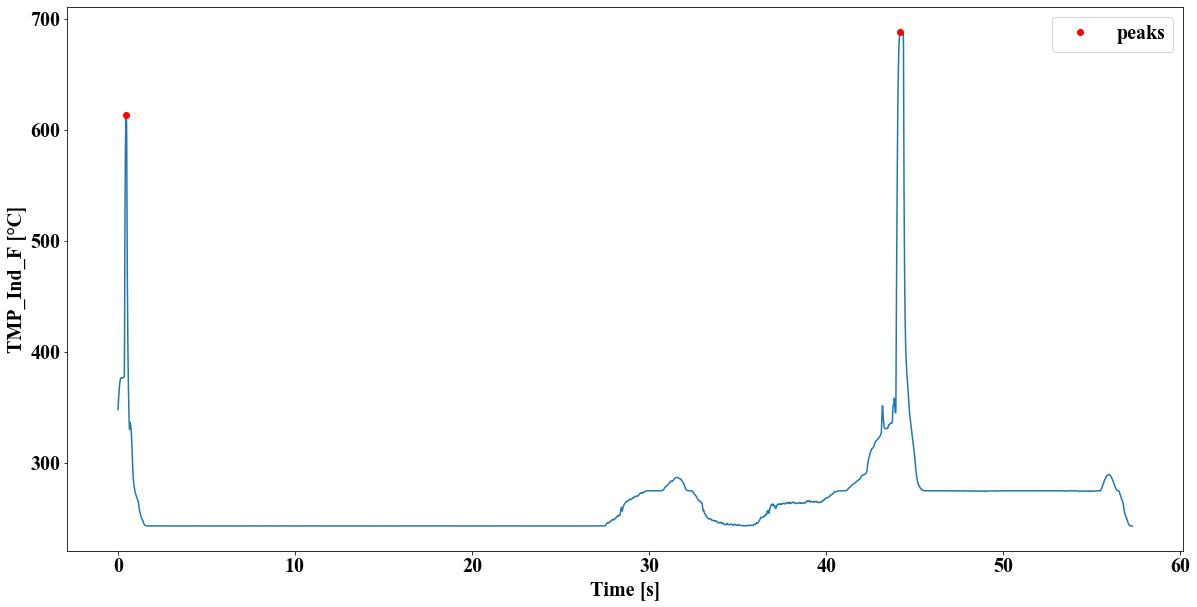

In [40]:
plt.plot(df['TMP_Ind_F [°C]'])

peaksTemp2, _ = find_peaks(df['TMP_Ind_F [°C]'].values, prominence=150)

plt.plot(df['TMP_Ind_F [°C]'].index[peaksTemp2], df['TMP_Ind_F [°C]'].iloc[peaksTemp2], 'o', color="r" , label="peaks")
plt.ylabel('TMP_Ind_F [°C]')
plt.xlabel("Time [s]")
plt.legend()

Also, mean temperature of the forging box and rate of increace of temperature of the forging box could be useful features beacuse it is the measure of energy absorbed by forging box. Angle of linear fit will be taken as measure of rate of increase of temperature during the forging phase.

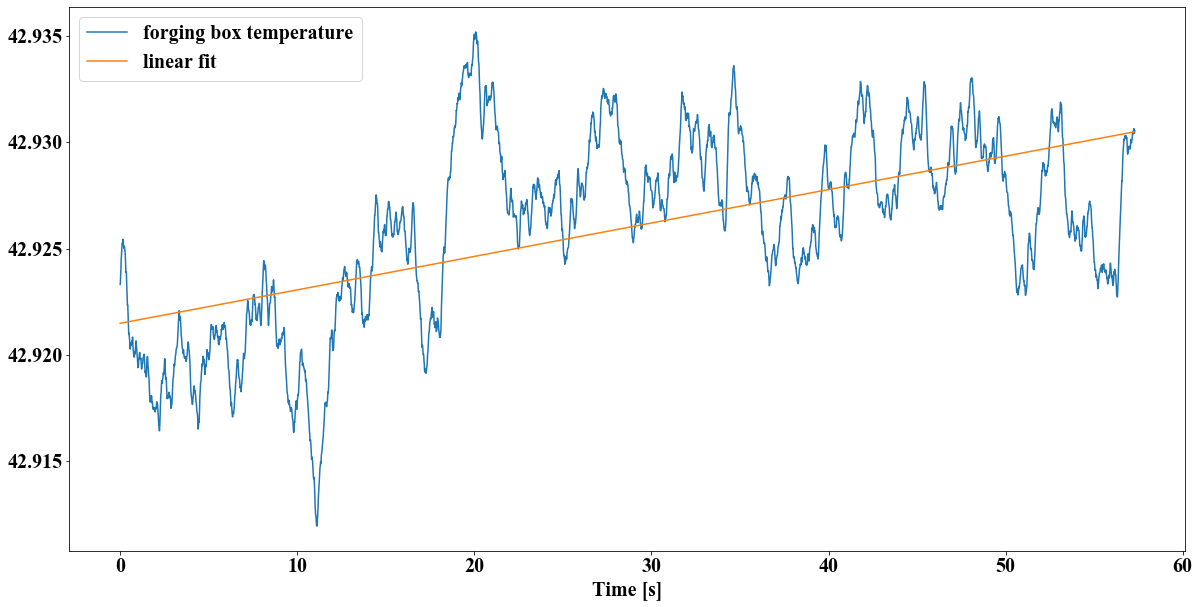

In [41]:
plt.plot(df['ForgingBox_Temp'], label="forging box temperature")

box_temp_ROI_coeffs=np.polyfit(df['ForgingBox_Temp'].index, df['ForgingBox_Temp'], 1)

#plt.plot(df['TMP_Ind_F [°C]'].index[peaksTemp2], df['TMP_Ind_F [°C]'].iloc[peaksTemp2], 'o', color="r" , label="peaks")
plt.plot(df['ForgingBox_Temp'].index, df['ForgingBox_Temp'].index*box_temp_ROI_coeffs[0]+box_temp_ROI_coeffs[1], label="linear fit")
plt.xlabel("Time [s]")
plt.legend()



In [42]:
forging_temp_features=pd.DataFrame(index=pd.RangeIndex(1,len(data)+1))

forging_temp_features['Forging Temperature Start [K]']=np.nan
forging_temp_features['Forging Temperature ROI [K/s]']=np.nan
forging_temp_features['Forging Box Temperature Mean [K]']=np.nan
forging_temp_features['Forging Box Temperature ROI [K/s]']=np.nan



In [43]:
for idx, df in enumerate(real_forge):
    temp_pyr_2=df['TMP_Ind_F [°C]']
    
    peaksTemp, _ = find_peaks(temp_pyr_2.values, prominence=150)
    assert(len(peaksTemp)==2)
    
    forging_temp_features['Forging Temperature Start [K]'][idx+1] = temp_pyr_2.iloc[peaksTemp[0]]
    forging_temp_features['Forging Temperature ROI [K/s]'][idx+1]=(temp_pyr_2.iloc[peaksTemp[1]]-temp_pyr_2.iloc[peaksTemp[0]])/(df.index[peaksTemp[1]]-df.index[peaksTemp[0]])
    
    temp_box=df['ForgingBox_Temp']
    box_temp_ROI_coeffs=np.polyfit(temp_box.index, df['ForgingBox_Temp'], 1)
    forging_temp_features['Forging Box Temperature ROI [K/s]'][idx+1]=box_temp_ROI_coeffs[0]
    forging_temp_features['Forging Box Temperature Mean [K]'][idx+1]=np.mean(temp_box)
    

In [44]:
forging_temp_features.head()

,Forging Temperature Start [K],Forging Temperature ROI [K/s],Forging Box Temperature Mean [K],Forging Box Temperature ROI [K/s]
1,602.732083,1.618284,36.192435,0.001645
2,606.262317,1.906290,36.571765,0.002713
3,609.255466,1.838307,36.930623,0.001947
4,609.371109,1.838493,37.268789,0.001906
5,609.832020,1.815287,37.543507,0.001587


## Exporting features to .csv files..

In [45]:
forging_temp_features.to_csv('forging_temp_features.csv')
forging_force_features.to_csv('forging_force_features.csv')